In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import silhouette_score

In [63]:
# Load the data
file_path = './BindingDB_All.tsv'
data = pd.read_csv(file_path, sep='\t', nrows=100000)

/var/folders/7z/y2p4cj3n02g7g064sxpd55380000gn/T/ipykernel_1123/1291846272.py:3: DtypeWarning: Columns (8,9,10,11,15,17,21,43,45,46,47,48,50,51,52,53,54,55,57,58,59,62,63,64,65,66,67,69,70,71,72,74,75,76,77,78,79) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, sep='\t', nrows=100000)


In [64]:
# Extract the 'Ligand SMILES' column into a DataFrame
mols_df = pd.DataFrame(data['Ligand SMILES'])

In [65]:
# Generate fingerprints (Morgan fingerprints with radius 2, 2048 bits)
fps = []
for smiles in mols_df["Ligand SMILES"]:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        # Generate the Morgan fingerprint
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        fps.append(np.array(fp))  # Convert to numpy array
    else:
        fps.append(None)

[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerator
[15:57:30] DEPRECATION WARNING: please use MorganGenerat

In [66]:
# Add the fingerprints as a new column
mols_df["FP_2048b_r2"] = fps

# Remove any rows where the fingerprint is None (invalid SMILES)
mols_df.dropna(subset=["FP_2048b_r2"], inplace=True)

In [67]:
# Stack the fingerprints into a 2D numpy array (each row is a fingerprint)
X = np.array([fp for fp in mols_df["FP_2048b_r2"]])

# Standardize the fingerprints (important for PCA and clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [68]:
# Apply PCA (reduce to 2D for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

Text(0, 0.5, 'Silhouette score')

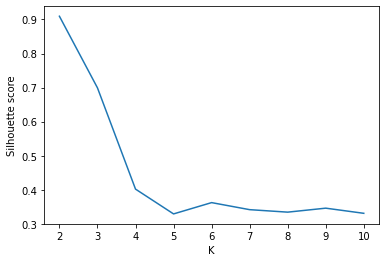

In [69]:
silhouettes = []

# Try multiple k
for k in range(2, 11):
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=10).fit_predict(X_pca)
    # Get the Silhouette score
    score = silhouette_score(X_pca, labels)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")

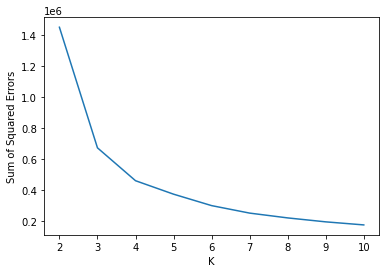

In [70]:
def plot_sse(features_X, start=2, end=11):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(features_X)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")
    
plot_sse(X_pca)

In [75]:
# K-means clustering 
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
mols_df['Cluster'] = kmeans.fit_predict(X_scaled)

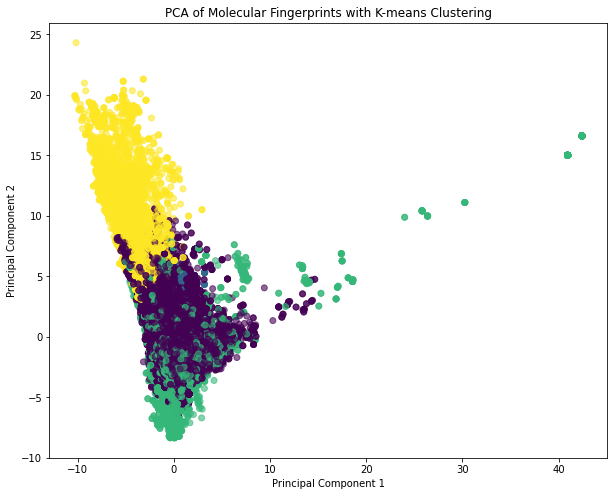

In [76]:
# Step 4: Plot the PCA results with cluster colors
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=mols_df['Cluster'], cmap='viridis', alpha=0.6)
plt.title('PCA of Molecular Fingerprints with K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
